# Análisis de Privacidad de Usuario: ¿Cambio natural de paradigma o agenda forzada?
## Trabajo Integrador Individual
## "De Texto Crudo a Insights: Pipeline Completo de Análisis de NLP"

**Fecha de entrega**: Jueves 25 de septiembre  

---

## Import de librerias

In [30]:
## 1.X
import requests
from bs4 import BeautifulSoup
import pandas as pd

import os
import re
import shutil
from google.colab import files
from urllib.parse import urlparse

# Manejo de errores
import traceback

## 2.X
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy

from collections import Counter



In [31]:
# Import pesado - Ejecutar una sola vez
# Stanza, para otros modelos de lematizacion
!pip install stanza
import stanza
# Descargar el modelo para español (solo la primera vez)
stanza.download('es')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: es (Spanish) ...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


## Contexto

### 1.0 Selección de ideas anteriores

#### Intento de Corpus literario

Se han revisado varias fuentes posibles de información para cuentos contemporáneos o de autores latinoamericanos pero encontré varios problemas a la hora de seleccionar el corpus de este formato que cumpla con el criterio minimo de volumen para procesarlo...

#### Project Gutenberg
Usando https://www.gutenberg.org/browse/languages/es

Autor elegido: Blasco Ibáñez, Vicente, 1867-1928

No tenia suficiente volumen digerible para cuentos y las obras parecían dispersas y repetidas

No tuve forma de encontrar en una forma concisa autores argentinos o latinoamericanos que estén en Gutenberg y que dispongan de mucho material usable para el proyecto... Podria buscar a mano pero tardaria mucho

Se intentó recolectar datos con
* Cuentos valencianos
https://www.gutenberg.org/ebooks/66514

* La condenada (cuentos)
https://www.gutenberg.org/ebooks/27736

* La Catedral

Entre otros...

#### Biblioteca Digital Argentina
La página no se encuentra disponible, y las alternativas no son lo suficientemente voluminosas o contemporaneas para el target que se busca

#### Cervantes Virtual
Mayoritariamente autores españoles, se buscaban autores latinoamericanos

#### Ciudad Seva
De algun modo no me convenció del todo, y preferí buscar otro tipo de corpus para entonces

### 1.1 Descripción del corpus elegido
Se decide entonces recolectar información relacionada al tema *tecnología*, con énfasis en el asunto de **privacidad**.

#### Fuentes seleccionadas

Fuentes elegidas
- https://derechodelared.com/
- https://www.anred.org/
- https://www.pagina12.com.ar/

Se omiten otros sitios periodisticos como Clarin, La Nación e Infobae ya que no proporcionaban suficiente información relevante al filtro que queremos aplicar

---

Yapa - No usables pero interesantes para tener en RSS posiblemente?
- https://www.elladodelmal.com/
- (Listado con más blogs y sitios periodisticos) https://www.genbeta.com/seguridad/17-expertos-blogs-y-newsletter-a-seguir-si-de-verdad-te-interesan-seguridad-y-privacidad


### 1.2 Justificación de elección

#### ¿Por qué este corpus?

La razón principal ocurre por dos factores:
- A nivel temático, es un asunto contemporáneo que, como otros rubros de la ciencia, está constantemente en transformación y más considerando las tendencias de desarrollos de tecnologías automatizadas que se profundizaron en la última década.
- Al ser un asunto popular, aporta un buen volumen con suficiente variabilidad para elegir algún tema específico sin que falten recursos para hacer una retrospectiva
- Si bien fue un tema de debate durante el 2015 al 2020, el asunto de privacidad e integridad de datos de usuario es un tema que sigue siendo relevante y que no habria que perder de vista, más considerando el factor de recolección de datos usados para modelos de IA

#### ¿Qué buscamos descubrir?

El enfoque de este corpus a analizar es el poder encontrar más contexto sobre los actores en juego a la hora de avanzar con ciertos cambios en la cotidianeidad del uso de nuestros datos personales

#### Hipotesis: "¿De verdad es necesario todo esto?"
¿Son realmente necesarias las nuevas exigencias en los términos y condiciones modificados?

¿Por qué se necesitan nuevas regulaciones año tras año de parte de protección de datos?

¿El factor económico de redistribución de datos personales sigue siendo tan presente como hace 5 años?

La hipótesis que planteo es que si bien se vió enlentecido el proceso de nuevos requerimientos que involucren vender nuestra privacidad de datos personales, sigue siendo igual de relevante que durante la década pasada.


### 1.3 Proceso de recolección

Los textos fueron obtenidos a mano a través de las fuentes mencionadas en 1.1, utilizando las palabras "privacidad" y "datos personales" en los buscadores integrados de dichas páginas. Se ha incluido una fuente adicional usando un buscador como DuckDuckGo.

#### Criterios de inclusión/exclusión

Se determina la exclusión de artículos que contengan:
- Alto contenido en imágenes en formato de infografías
- Contenido relacionado a la privacidad de una persona en particular (política/celebridad o no), a menos que se mencione información que aporte al contexto general del corpus
- Anuncios de aplicaciones nuevas que puedan proporcionar alternativas a las comunes (usualmente están orientadas a cubrir las características del programa en vez de informar en general)

#### Dificultades y obstáculos

En la obtención de recursos he encontrado los siguientes obstáculos:

- Calidad de artículos gratuitos. Se encontraron los suficientes para cubrir casos recientes, pero muchos artículos se encuentran restringidos para usuarios registrados a newsletters.
- Web scraping - La estructura de metadatos HTML varía mucho entre distintas fuentes. Un ejemplo de esto es al buscar el título de los artículos de www.derechodelared.com, la falta de dato de autor en los de www.anred.org, o los formatos variantes en fechas, etc.
- Falta de tiempo para organizarme mejor. Muchas tareas en paralelo impidieron una mejor calidad de recolección.


### 1.4 Estadísticas básicas

#### Código inicial

##### Obtención de listado de URLs
Las urls a probar de mi corpus están guardadas en un .txt dentro del repositorio

In [2]:
# 003_barthou-gonzalo-nlp-integrador/corpus/corpusList.txt

# URL cruda del archivo en GitHub
github_txt_url = "https://raw.githubusercontent.com/gimb99/PDH_BARTHOU_GONZALO/refs/heads/main/003_barthou-gonzalo-nlp-integrador/corpus/corpusList.txt"

# Descargar y procesar las líneas
response = requests.get(github_txt_url)
lines = response.text.splitlines()
urls = [line.strip() for line in lines if line.strip()]


##### Guardado de .txt como archivos raw

In [3]:
# Crear carpeta para guardar los archivos
folder = "raw_texts"
os.makedirs(folder, exist_ok=True)

# Función para limpiar el nombre del archivo
def clean_filename(title, index):
    title = re.sub(r'[^\w\s-]', '', title).strip().replace(' ', '_')
    return f"{index:03d}_{title[:50]}.txt"  # Limita el nombre a 50 caracteres

default_no_disponible = "No disponible"

# Recorrer las URLs
for i, url in enumerate(urls, start=1):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Extraer título y texto (ajustar según el sitio)
        domain = urlparse(url).netloc
        try:
          if "derechodelared.com" in domain:
            title = soup.find("meta", property="og:title")["content"]
            autor_crudo = soup.find("a", attrs={"rel": "author"})
            autor_tag = default_no_disponible
            if autor_crudo:
              autor_tag = autor_crudo.get_text(strip=True)

            fecha_tag = soup.find("meta", property="article:published_time")["content"]
            categoria_tag = soup.find("a", rel="category tag").get_text(strip=True)
          elif "www.pagina12.com" in domain:
            title = soup.find("meta", property="og:title")["content"]
            autor_tag = soup.find("meta", property="article:author")["content"]
            fecha_tag = soup.find("meta", property="article:published_time")["content"]
            categoria_tag = soup.find("meta", property="article:section")["content"]
          elif "anred" in domain:
            title = soup.find("meta", property="og:title")["content"]
            # No se encuentran autores en muchos articulos, se procede a dejar en default
            # autor_tag = soup.find("meta", property="article:author")["content"]
            autor_tag = default_no_disponible
            #fecha_tag = soup.find("div", class_="date text-muted")
            # 1. Localizar el div
            fecha_crudo = soup.find("div", class_="date text-muted")
            # 2. Extraer solo el texto y limpiarlo
            fecha_texto = fecha_crudo.get_text(strip=True)  # -> "14/03/2023"
            # 3. Parsear a objeto fecha de Python
            from datetime import datetime
            fecha_tag = datetime.strptime(fecha_texto, "%d/%m/%Y")

            categoria_tag = soup.find("meta", property="article:section")["content"]
          else:
            title = soup.find("h1").get_text(strip=True)
        except Exception as e:
          print(f"❌ Error con datos de {url}: {e}")
          traceback.print_exc()
          title = f"articulo_{i}"

        paragraphs = soup.find_all("p")

        # Guardado datos en variables
        text = "\n".join([p.get_text(strip=True) for p in paragraphs])
        #autor_fuente = autor_tag.get_text(strip=True) if autor_tag else default_no_disponible
        autor_fuente = autor_tag if autor_tag else default_no_disponible
        #fecha = fecha_tag.get_text(strip=True) if fecha_tag else ""
        fecha = fecha_tag if fecha_tag else default_no_disponible
        #categoria = categoria_tag.get_text(strip=True) if categoria_tag else default_no_disponible
        categoria = categoria_tag if categoria_tag else default_no_disponible

        # Guardar como archivo .txt
        filename = clean_filename(title, i)
        filepath = os.path.join(folder, filename)

        with open(filepath, "w", encoding="utf-8") as f:
            f.write(f"URL: {url}\n")
            f.write(f"Título: {title}\n")
            f.write(f"Autor: {autor_fuente}\n")
            f.write(f"Fecha: {fecha}\n")
            f.write(f"Categoría: {categoria}\n\n")
            f.write(text)

        print(f"✅ Guardado: {filename}")

    except Exception as e:
        print(f"❌ Error con {url}: {e}")

✅ Guardado: 001_Tiktok_se_enfrenta_a_una_posible_multa_de_27_millo.txt
✅ Guardado: 002_Manzana_podrida_decenas_de_exespías_israelíes_fuer.txt
✅ Guardado: 003_El_auge_del_tecnofeudalismo__ANRed.txt
✅ Guardado: 004_Qué_hay_detrás_de_las_colas_para_la_venta_de_iris_.txt
✅ Guardado: 005_Sam_Altman_creador_de_ChatGPT_y_GPT-4_mi_peor_temo.txt
✅ Guardado: 006_Natalia_Zuazo_el_problema_es_cuando_el_avance_de_l.txt
✅ Guardado: 007_Espionaje_ilegal_del_Ministerio_de_Seguridad_porte.txt
✅ Guardado: 008_Pensamiento_crítico_De_verdad_sabemos_qué_hacemos_.txt
✅ Guardado: 009_CABA_la_Legislatura_porteña_debate_un_polémico_pro.txt
✅ Guardado: 010_WhatsApp_no_cerrará_cuentas_pero_limitará_funcione.txt
✅ Guardado: 011_Polisis_una_IA_que_se_lee_las_políticas_de_privaci.txt
✅ Guardado: 012_La_AEPD_presenta_nuevos_recursos_para_fomentar_la_.txt
✅ Guardado: 013_Chat_Control_el_plan_europeo_para_escanear_tus_men.txt
✅ Guardado: 014_La_NSA_compra_datos_de_navegación_de_los_usuarios_.txt
✅ Guardado: 015_Micros

##### Textos debug / desarrollo - Ignorar

Elminar carpeta para reintentar

In [ ]:
# Eliminar carpeta

# folder = "raw_texts"
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#             print(f"🗑️ Borrado: {filename}")
#     except Exception as e:
#         print(f"❌ Error con {filename}: {e}")

Guardado de zip

In [ ]:
# Guardado de .zip para luego extraerlo y subirlo a github
# shutil.make_archive("raw_texts", "zip", "raw_texts")
# files.download("raw_texts.zip")

##### Guardado de metadata.csv v2

In [ ]:
folder = "raw_texts"
metadata = []

for filename in os.listdir(folder):
    filepath = os.path.join(folder, filename)

    if os.path.isfile(filepath) and filename.endswith(".txt"):
        with open(filepath, "r", encoding="utf-8") as f:
            content = f.read()

        # Separar líneas para buscar metadatos
        lines = content.splitlines()

        # Extraer título, autor, fecha, categoría (si están presentes)
        titulo = ""
        autor_fuente = ""
        fecha = ""
        categoria = ""

        for line in lines[:10]:  # Buscar en las primeras líneas
            if line.lower().startswith("título:"):
                titulo = line.split(":", 1)[1].strip()
            elif line.lower().startswith("autor:") or line.lower().startswith("fuente:"):
                autor_fuente = line.split(":", 1)[1].strip()
            elif line.lower().startswith("fecha:"):
                fecha = line.split(":", 1)[1].strip()
            elif line.lower().startswith("categoría:"):
                categoria = line.split(":", 1)[1].strip()

        # Calcular número aproximado de palabras
        cuerpo = "\n".join(lines[10:])  # Suponiendo que el cuerpo empieza después de los metadatos
        palabras_aprox = len(cuerpo.split())

        metadata.append({
            "archivo": filename,
            "titulo": titulo,
            "autor_fuente": autor_fuente,
            "fecha": fecha,
            "categoria": categoria,
            "palabras_aprox": palabras_aprox
        })

# Guardar como CSV
df = pd.DataFrame(metadata)
df.to_csv("metadata.csv", index=False)


#### Número total de textos


##### Paso 0 - Get de metadata.csv desde GitHub

In [ ]:
# Opción A: si subiste metadata.csv directamente al espacio de Colab
# df = pd.read_csv("metadata.csv")

# Opcion B / Obtener de github
# URL cruda del archivo en GitHub
github_metadata_url = "https://raw.githubusercontent.com/gimb99/PDH_BARTHOU_GONZALO/refs/heads/main/003_barthou-gonzalo-nlp-integrador/corpus/metadata.csv"

# Descargar y procesar las líneas
# response = requests.get(github_txt_url)
df = pd.read_csv(github_metadata_url)

##### Paso Real

In [ ]:
# 2.1 Número total de textos
total_textos = len(df)
print("Total de textos:", total_textos)

Total de textos: 26


#### Número total de palabras

In [ ]:
total_palabras = df["palabras_aprox"].sum()
print("Total aproximado de palabras:", total_palabras)

Total aproximado de palabras: 25695


#### Distribución de tamaños de documentos

count      26.000000
mean      988.269231
std       841.510526
min        61.000000
25%       283.000000
50%       706.000000
75%      1776.250000
max      2585.000000
Name: palabras_aprox, dtype: float64


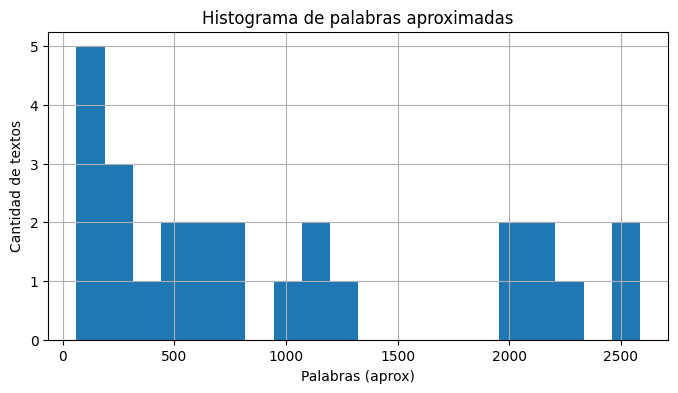

In [ ]:
# Estadísticos básicos
print(df["palabras_aprox"].describe())

# Histograma con pandas/matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
df["palabras_aprox"].hist(bins=20)
plt.title("Histograma de palabras aproximadas")
plt.xlabel("Palabras (aprox)")
plt.ylabel("Cantidad de textos")
plt.show()


#### Gráfico de distribución temporal

/tmp/ipython-input-4053633844.py:2: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")


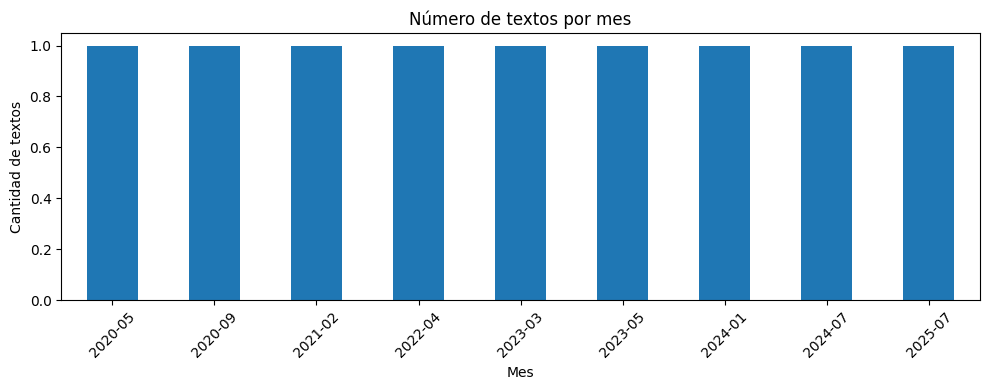

In [ ]:
# Convertir 'fecha' a datetime (ajusta el formato si es necesario)
df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")

# Agrupar por mes
df_mes = df.groupby(df["fecha"].dt.to_period("M")).size()

# Dibujar
df_mes.plot(kind="bar", figsize=(10,4))
plt.title("Número de textos por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de textos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La distribución no da resultados eficientes dado que no se obtuvo una fecha con el mismo formato para todos los artículos. Por tanto, no es posible aplicar una distribución temporal a menos que se fixee el formato final en metadata.csv

### 1.5 Exploración inicial

##### Carga de datos

In [ ]:
# Limpiador
def clean_text(text):
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Eliminar emails
    text = re.sub(r'\S+@\S+', '', text)
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar puntuación y caracteres especiales (solo dejar letras y espacios)
    text = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', ' ', text)
    # Reemplazar múltiples espacios por uno solo
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Directorio donde están los archivos .txt
corpus_dir = "/content/raw_texts/"  # Ajusta esta ruta

pattern = re.compile(r"URL:.*?\n\n(.*)", re.DOTALL)
all_texts = []

for filename in os.listdir(corpus_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(corpus_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            match = pattern.search(content)
            if match:
                text_body = match.group(1).strip()
                # Limpiar el texto antes de agregarlo
                cleaned_text = clean_text(text_body)  # Asumiendo que tienes esta función
                all_texts.append(cleaned_text)

# Verificar cómo se están uniendo los textos
print("Primeros 1000 caracteres de corpus_full_text:")
corpus_full_text = " ".join(all_texts)
print(repr(corpus_full_text[:1000]))

# Ahora `texts` contiene solo los cuerpos de los artículos

Primeros 1000 caracteres de corpus_full_text:
'La Agencia de Seguridad Nacional de Estados Unidos NSA ha admitido haber comprado registros de navegación por Internet a empresas especializadas en la recopilación de datos para vigilar la actividad en línea de los estadounidenses sin tener una orden judicial para ello La noticia ha saltado después de que el senador demócrata estadounidenseRon Wyden hiciese públicos unos documentos dónde se confirmaque la Agencia de Seguridad Nacional NSA compra los registros de navegación por Internet de los estadounidenses sin orden judicial Pueden parecer datos sin importancia pero a través de ellos se puede saber las webs que visitan los ciudadanos estadounidenses que aplicaciones tienen intereses inquietudes Mucha información Por ello Wyden ha pedido al Gobierno norteamericano que cesen en esta practica remarcando que según una orden reciente de la Comisión Federal de Comercio FTC estas empresas que se dedican a la recopilación masiva de datos no pued

#### Mostrar fragmentos representativos

In [ ]:
# Mostrar primeros 300 caracteres de los primeros 3 textos
for i, text in enumerate(texts[:3]):
    print(f"Fragmento del texto {i+1}:")
    print(text[:300])
    print("-" * 50)

Fragmento del texto 1:
La Agencia de Seguridad Nacional de Estados Unidos NSA ha admitido haber comprado registros de navegación por Internet a empresas especializadas en la recopilación de datos para vigilar la actividad en línea de los estadounidenses sin tener una orden judicial para ello La noticia ha saltado después 
--------------------------------------------------
Fragmento del texto 2:
LaAgencia Española de Protección de Datos AEPD ha presentado junto con elMinisterio de Educación Cultura y Deportenuevos recursos y materiales de ayuda para fomentar la privacidad y la protección de datos de los menores Estos recursos se incorporan a la web de la AgenciaTú decides en internet un pro
--------------------------------------------------
Fragmento del texto 3:
La digitalización de nuestras relaciones cotidianas provoca que cedamos datos personales infinidad de veces al día Y los cambios constantes no permiten que lo hagamos de forma consciente e informada Por Elena Gil González Resum

#### Nube de palabras inicial

In [ ]:
# Import de librerias
from wordcloud import WordCloud
import matplotlib.pyplot as plt

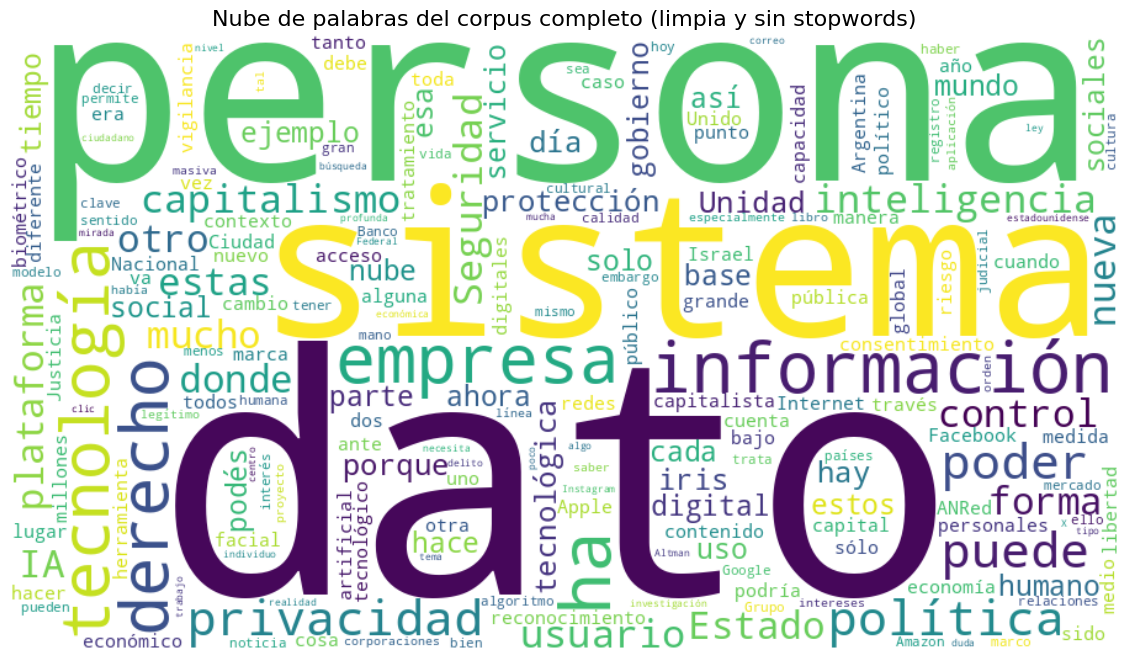

In [ ]:
from wordcloud import STOPWORDS

# Agregar stopwords en español
spanish_stopwords = {
     "el", "la", "de", "que", "y", "a", "en", "un", "es", "se", "no", "te", "lo", "le", "da",
    "su", "por", "son", "con", "para", "al", "del", "los", "las", "una", "como", "pero",
    "sus", "han", "muy", "sin", "sobre", "ser", "todo", "esta", "hasta", "fue", "más",
    "son", "han", "tiene", "han", "haya", "tienen", "tendrá", "tienen", "está", "están",
    "mi", "mis", "tu", "tus", "su", "sus", "nos", "vos", "vosotros", "ustedes", "yo", "él",
    "ella", "nosotros", "ellos", "ellas", "me", "te", "le", "nos", "os", "les", "lo", "la",
    "los", "las", "mío", "mía", "míos", "mías", "tuyo", "tuya", "tuyos", "tuyas", "suyo",
    "suya", "suyos", "suyas", "nuestro", "nuestra", "nuestros", "nuestras", "vuestro",
    "vuestra", "vuestros", "vuestras", "esto", "eso", "aquello", "este", "ese", "aquel",
    "aquí", "ahí", "allí", "cuándo", "dónde", "cómo", "qué", "quién", "cuánto", "cuánta",
    "cuántos", "cuántas", "por qué", "para qué", "hacia", "entre", "desde", "hasta", "contra",
    "según", "durante", "mediante", "salvo", "excepto", "incluso", "mientras", "aunque",
    "si", "sino", "o", "ni", "pero", "mas", "y", "e", "u", "o", "ya", "todavía", "aún",
    "siempre", "nunca", "jamás", "también", "tampoco", "además", "asimismo", "igualmente",
    "finalmente", "entonces", "luego", "por tanto", "por consiguiente", "por ende", "por lo tanto"
}
stopwords = set(STOPWORDS)
stopwords.update(spanish_stopwords)

# Generar la nube
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color="white",
    max_words=200,
    stopwords=stopwords,
    colormap="viridis",
    collocations=False,
    ).generate(corpus_full_text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras del corpus completo (limpia y sin stopwords)", fontsize=16)
plt.show()

#### Debugging - Ignorar

## Análisis Técnico

###  2.1: Carga y organización de datos

#### Unificando metadata con corpus

In [ ]:
import pandas as pd
import os
import re

# Cargar el archivo metadata.csv
github_metadata_url = "https://raw.githubusercontent.com/gimb99/PDH_BARTHOU_GONZALO/refs/heads/main/003_barthou-gonzalo-nlp-integrador/corpus/metadata.csv"
metadata_path = github_metadata_url
metadata_df = pd.read_csv(metadata_path)

# Directorio donde están los archivos .txt
#corpus_dir = "/content/drive/MyDrive/corpus_txt"  # Ajusta esta ruta

# Patrón para extraer solo el cuerpo del texto
pattern = re.compile(r"URL:.*?\n\n(.*)", re.DOTALL)

# Diccionario para almacenar cuerpos de texto indexados por nombre de archivo
corpus_dict = {}

for filename in os.listdir(corpus_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(corpus_dir, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            match = pattern.search(content)
            if match:
                text_body = match.group(1).strip()
                corpus_dict[filename] = text_body
            else:
                print(f"Advertencia: No se pudo extraer el cuerpo de {filename}")

# Añadir el cuerpo del texto al DataFrame
metadata_df['cuerpo'] = metadata_df['archivo'].apply(lambda x: corpus_dict.get(x, None))

# Verificar si hay valores faltantes en la columna 'cuerpo'
print("Verificación de integridad:")
print(f"Total de documentos en metadata: {len(metadata_df)}")
print(f"Documentos con cuerpo de texto: {metadata_df['cuerpo'].notna().sum()}")
print(f"Documentos sin cuerpo de texto: {metadata_df['cuerpo'].isna().sum()}")

Verificación de integridad:
Total de documentos en metadata: 26
Documentos con cuerpo de texto: 26
Documentos sin cuerpo de texto: 0


#### Valido que se hayan cargado correctamente

In [ ]:
# Mostrar las primeras filas para verificar la integración
print("\nPrimeras filas del DataFrame integrado:")
print(metadata_df[['archivo', 'titulo', 'autor_fuente', 'fecha', 'categoria', 'palabras_aprox', 'cuerpo']].head())


Primeras filas del DataFrame integrado:
                                             archivo  \
0         003_El_auge_del_tecnofeudalismo__ANRed.txt   
1  011_Polisis_una_IA_que_se_lee_las_políticas_de...   
2  007_Espionaje_ilegal_del_Ministerio_de_Segurid...   
3  023_Apple_multada_Francia_sanciona_con_162_mil...   
4  004_Qué_hay_detrás_de_las_colas_para_la_venta_...   

                                              titulo    autor_fuente  \
0                El auge del tecnofeudalismo | ANRed   No disponible   
1  Polisis: una IA que se lee las políticas de pr...  Julio San José   
2  Espionaje ilegal del Ministerio de Seguridad p...   No disponible   
3  Apple multada: Francia sanciona con $162 millo...        Página12   
4  ¿Qué hay detrás de las colas para la venta de ...   No disponible   

                       fecha             categoria  palabras_aprox  \
0        2024-07-14 00:00:00               Opinión            2585   
1  2019-10-30T18:00:50+00:00                 Cybe

#### Guardado en Pickle inicial

In [ ]:
# Guardar en un archivo .pkl para futuras operaciones
metadata_df.to_pickle("corpus_crudo.pkl")

#### Validacion de fechas inconsistentes
Dado que no pude obtener fechas de forma consistente por usar varias fuentes, pruebo si es posible pasar a tenerlas en un formato date_time

Encontramos que la mayoria de los datos de fecha son no validos para hacer un pasaje, de igual forma intenta recuperarse los que son validos...

##### Conversión fecha Epoch

In [ ]:
# Función para intentar convertir fechas EPOCH
def convertir_fecha_epoch(valor):
    try:
        # Intentar convertir a número
        epoch = float(valor)
        # Verificar si es un timestamp razonable (entre 1970 y 2030 aprox.)
        if 315360000 < epoch < 2000000000:  # Años entre 1980 y 2033 aprox.
            return pd.to_datetime(epoch, unit='s')
        else:
            return pd.NaT  # No es una fecha válida
    except:
        return pd.NaT

In [ ]:
# Asumiendo que tienes el DataFrame con la columna 'fecha'
df = pd.read_pickle("corpus_crudo.pkl")  # Si ya lo tienes guardado

# Intentar convertir las fechas inválidas como si fueran EPOCH
df['fecha_dt'] = pd.to_datetime(df['fecha'], errors='coerce')
df['fecha_epoch'] = df['fecha'].apply(convertir_fecha_epoch)

# Combinar las fechas válidas con las convertidas desde EPOCH
df['fecha_final'] = df['fecha_dt'].fillna(df['fecha_epoch'])

# Verificar cuántas fechas pudieron convertirse ahora
validas = df['fecha_final'].notna().sum()
invalidas = df['fecha_final'].isna().sum()

print(f"Fechas válidas tras intento de conversión EPOCH: {validas}")
print(f"Fechas aún inválidas: {invalidas}")

# Mostrar las fechas aún inválidas
fechas_invalidas = df[df['fecha_final'].isna()]
print("\nFechas aún inválidas:")
print(fechas_invalidas[['archivo', 'fecha']])

Fechas válidas tras intento de conversión EPOCH: 19
Fechas aún inválidas: 7

Fechas aún inválidas:
                                              archivo  \
1   011_Polisis_una_IA_que_se_lee_las_políticas_de...   
6   013_Chat_Control_el_plan_europeo_para_escanear...   
8   015_Microsoft_mantendrá_en_la_UE_los_datos_per...   
18  014_La_NSA_compra_datos_de_navegación_de_los_u...   
22  012_La_AEPD_presenta_nuevos_recursos_para_fome...   
23  001_Tiktok_se_enfrenta_a_una_posible_multa_de_...   
24  010_WhatsApp_no_cerrará_cuentas_pero_limitará_...   

                        fecha  
1   2019-10-30T18:00:50+00:00  
6   2025-09-14T18:15:40+00:00  
8   2024-01-15T18:29:59+00:00  
18  2024-01-29T19:07:17+00:00  
22  2017-10-23T18:34:41+00:00  
23  2022-09-26T18:15:45+00:00  
24  2021-05-11T19:04:55+00:00  


##### Correccion de fechas en formato ISO 8601

In [ ]:
# Intentar convertir las fechas que aún están como inválidas
fechas_restantes = df[df['fecha_final'].isna()]

# Intentar convertir con formato ISO 8601 explícito
df.loc[df['fecha_final'].isna(), 'fecha_final'] = pd.to_datetime(
    df[df['fecha_final'].isna()]['fecha'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce'
)

# Verificar cuántas fechas pudieron convertirse ahora
validas = df['fecha_final'].notna().sum()
invalidas = df['fecha_final'].isna().sum()

print(f"Fechas válidas tras intento de conversión ISO 8601: {validas}")
print(f"Fechas aún inválidas: {invalidas}")

# Mostrar las fechas aún inválidas
fechas_invalidas = df[df['fecha_final'].isna()]
if not fechas_invalidas.empty:
    print("\nFechas aún inválidas:")
    print(fechas_invalidas[['archivo', 'fecha']])
else:
    print("\n¡Todas las fechas pudieron convertirse!")

Fechas válidas tras intento de conversión ISO 8601: 26
Fechas aún inválidas: 0

¡Todas las fechas pudieron convertirse!


/tmp/ipython-input-1088535155.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
['2019-10-30 18:00:50+00:00', '2025-09-14 18:15:40+00:00',
 '2024-01-15 18:29:59+00:00', '2024-01-29 19:07:17+00:00',
 '2017-10-23 18:34:41+00:00', '2022-09-26 18:15:45+00:00',
 '2021-05-11 19:04:55+00:00']
Length: 7, dtype: datetime64[ns, UTC]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[df['fecha_final'].isna(), 'fecha_final'] = pd.to_datetime(


In [ ]:
# Etiquetar si la fecha es válida o no
df['fecha_valida'] = df['fecha_final'].notna()

# Mostrar estadísticas
print("\nResumen de fechas:")
print(df['fecha_valida'].value_counts())


Resumen de fechas:
fecha_valida
True    26
Name: count, dtype: int64


#### Guardo dataframe limpio como Pickle

In [ ]:
# Guardar el DataFrame con la columna de fechas completamente corregida
df.to_pickle("corpus_limpio.pkl")

In [ ]:
print(df["fecha_final"])

0           2024-07-14 00:00:00
1     2019-10-30 18:00:50+00:00
2           2022-04-13 00:00:00
3           2025-04-03 15:24:34
4           2024-01-11 00:00:00
5           2024-12-20 21:20:46
6     2025-09-14 18:15:40+00:00
7           2025-04-05 20:52:35
8     2024-01-15 18:29:59+00:00
9           2023-05-17 00:00:00
10          2025-05-06 11:20:50
11          2021-02-21 00:00:00
12          2025-07-31 00:00:00
13          2025-05-06 11:20:50
14          2025-06-17 14:41:58
15          2020-05-09 00:00:00
16          2025-08-21 20:59:46
17          2025-08-21 20:59:46
18    2024-01-29 19:07:17+00:00
19          2025-03-27 19:58:54
20          2023-03-14 00:00:00
21          2025-08-30 00:31:10
22    2017-10-23 18:34:41+00:00
23    2022-09-26 18:15:45+00:00
24    2021-05-11 19:04:55+00:00
25          2020-09-18 00:00:00
Name: fecha_final, dtype: object


### 2.2 Limpieza de texto

In [4]:
import string

def clean_text_v2(text):
    # 1. Conversión a minúsculas
    # Justificación: Ayuda a que palabras como "La" y "la" se consideren iguales
    text = text.lower()

    # 2. Eliminación de signos de puntuación
    # Justificación: Elimina símbolos como .,;:!? que no aportan significado semántico
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Eliminación de números
    # Justificación: En este corpus (noticias), los números no son relevantes para el análisis
    text = re.sub(r'\d+', '', text)

    # 4. Eliminación de caracteres especiales y espacios extra
    # Justificación: Quita caracteres como \n, \t, y múltiples espacios
    text = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cargar el DataFrame con los cuerpos de texto
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio.pkl"
df = pd.read_pickle(github_pkl_path)

# Aplicar la limpieza a la columna 'cuerpo'
# Ya disponiamos de una funcion anteriormente, pero esta vez haremos
# una segunda pasada mas refinada
df['cuerpo_limpio'] = df['cuerpo'].apply(clean_text_v2)

# Mostrar una comparación antes y después
print("Antes de limpiar:")
print(df['cuerpo'].iloc[0][:500])
print("\nDespués de limpiar:")
print(df['cuerpo_limpio'].iloc[0][:500])

Antes de limpiar:
El capitalismo tal como lo conocíamos, afirma Yanis Varoufakis, ha mutado tanto que ha dado lugar a un nuevo sistema. En el tecnofeudalismo, los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas, y la burguesía de antaño está al servicio de una nueva clase dominante, aquella que es dueña de la nube. PorDavid Moscorp paraJacobin/ traducción: Florencia Oroz.
controvertido concepto de tecnofeudalismo sugiere que hemos pasado del capitalismo a algo aún peor: una

Después de limpiar:
el capitalismo tal como lo conocíamos afirma yanis varoufakis ha mutado tanto que ha dado lugar a un nuevo sistema en el tecnofeudalismo los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas y la burguesía de antaño está al servicio de una nueva clase dominante aquella que es dueña de la nube pordavid moscorp parajacobin traducción florencia oroz controvertido concepto de tecnofeudalismo sugiere que hemos pasado del ca

#### Pasos realizados
- Conversión de todo el corpus a minúsculas para normalización de texto
- Eliminación de signos de puntuación para optimizar valor semántico
- Eliminación de valores numéricos literales, así como de caracteres no imprimibles o especiales (éste ultimo ya estaba forzado por UTF-8 de todas formas)
- Reemplazo de múltiples espacios por uno simple para minimizar errores de análisis posteriores

#### Guardado de Corpus Limpio v2 como Pickle

In [6]:
# Guardar el DataFrame con los cuerpos limpios
df.to_pickle("corpus_limpio_v2.pkl")

### 2.3 Tokenización y normalización

#### ¿Qué es stemming y lemmatization?

- Stemming: Reduce las palabras a su raíz truncando el final (por ejemplo: "corriendo" → "corr").
- Lemmatization: Reduce las palabras a su forma base (lema) considerando el contexto gramatical (por ejemplo: "corriendo" → "correr").

#### ¿Qué usar?
Usaremos Lemmatization, ya que si bien es más lento, el uso de textos en español reduce la usabilidad analítica al usar Stemming y puede provocar una perdida de contexto en palabras complejas (el idioma tiene muchas formas verbales y variaciones gramaticales)

#### Aplicación

In [7]:
## Librerias usadas: nltk, spacy

# Descargar recursos necesarios
#nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Descarga forzada de modelo en español
!python -m spacy download es_core_news_sm

# Cargar modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 37.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


##### Tokenizacion (Pre-Normalizado)

In [8]:
# Cargar el DataFrame con los textos limpios
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v2.pkl"
df = pd.read_pickle(github_pkl_path)

# Ejemplo de texto limpio
ejemplo_texto = df['cuerpo_limpio'].iloc[0]
print("Texto limpio (ejemplo):")
print(ejemplo_texto[:500])

Texto limpio (ejemplo):
el capitalismo tal como lo conocíamos afirma yanis varoufakis ha mutado tanto que ha dado lugar a un nuevo sistema en el tecnofeudalismo los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas y la burguesía de antaño está al servicio de una nueva clase dominante aquella que es dueña de la nube pordavid moscorp parajacobin traducción florencia oroz controvertido concepto de tecnofeudalismo sugiere que hemos pasado del capitalismo a algo aún peor una nueva era 


In [9]:
# Tokenizar el texto
tokens = word_tokenize(ejemplo_texto)
print("\nTokens (antes de normalización):")
print(tokens[:20])


Tokens (antes de normalización):
['el', 'capitalismo', 'tal', 'como', 'lo', 'conocíamos', 'afirma', 'yanis', 'varoufakis', 'ha', 'mutado', 'tanto', 'que', 'ha', 'dado', 'lugar', 'a', 'un', 'nuevo', 'sistema']


##### Lematización

In [10]:
# Función para lematizar texto
def lemmatize_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

# Aplicar lematización
lemmatized_tokens = lemmatize_text(ejemplo_texto)
print("\nTokens lematizados (después de normalización):")
print(lemmatized_tokens[:20])


Tokens lematizados (después de normalización):
['el', 'capitalismo', 'tal', 'como', 'él', 'conocíar', 'afirmar', 'yani', 'varoufakis', 'haber', 'mutar', 'tanto', 'que', 'haber', 'dar', 'lugar', 'a', 'uno', 'nuevo', 'sistema']


In [16]:
### Debug
doc = nlp("conocíamos")
for token in doc:
    print(f"Palabra: {token.text}")
    print(f"Lema: {token.lemma_}")
    print(f"POS (Part-of-Speech): {token.pos_}")
    print(f"Tag (etiqueta detallada): {token.tag_}")
    print(f"¿Es verbo?: {token.pos_ == 'VERB'}")
    print("---")

Palabra: conocíamos
Lema: conocíar
POS (Part-of-Speech): VERB
Tag (etiqueta detallada): VERB
¿Es verbo?: True
---


#### Obstáculo

En la ejecución de esta ultima linea, llegué a notar que hay algunos verbos conjugados que se lematizan de forma incorrecta, esto puede ser ocasionado por una versión anterior del modelo de spaCy en español que puede disponer de imprecisiones como con la palabra "Conocíamos", que la traduce como "conocíar", de forma que ese verbo infinitivo no existe

Probaremos con `Stanza` a ver si tenemos suerte...



In [11]:
# Stanza - Usado con !pip, importa y modelo en español

# Inicializar el pipeline
nlp_stanza = stanza.Pipeline('es', processors='tokenize,pos,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [12]:
# Procesar la oración
doc = nlp_stanza("conocíamos")

for sentence in doc.sentences:
    for word in sentence.words:
        print(f"Palabra: {word.text}, Lema: {word.lemma}")

Palabra: conocíamos, Lema: conocer


#### Prueba de nuevo con Stanza

In [13]:
# Inicializar el pipeline de Stanza para español (solo una vez)
nlp_stanza = stanza.Pipeline('es', processors='tokenize,pos,lemma')

def lemmatize_with_stanza(text):
    doc = nlp_stanza(text)
    # Extraer solo los lemas de palabras que no son puntuación
    return [word.lemma for sent in doc.sentences for word in sent.words if word.pos != 'PUNCT']

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [14]:
# Cargar el DataFrame con los textos limpios
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v2.pkl"
df = pd.read_pickle(github_pkl_path)

# Aplicar lematización con Stanza
df['tokens_lemmatizados'] = df['cuerpo_limpio'].apply(lemmatize_with_stanza)

# Mostrar un ejemplo
print("Antes de normalización (texto limpio):")
print(df['cuerpo_limpio'].iloc[0][:300])
print("\nDespués de lematización con Stanza:")
print(df['tokens_lemmatizados'].iloc[0][:20])

Antes de normalización (texto limpio):
el capitalismo tal como lo conocíamos afirma yanis varoufakis ha mutado tanto que ha dado lugar a un nuevo sistema en el tecnofeudalismo los usuarios contribuyen a la formación de capital con solo interactuar con las plataformas y la burguesía de antaño está al servicio de una nueva clase dominante 

Después de lematización con Stanza:
['el', 'capitalismo', 'tal', 'como', 'él', 'conocer', 'afirmar', 'yanis', 'varoufakis', 'haber', 'mutar', 'tanto', 'que', 'haber', 'dar', 'lugar', 'a', 'uno', 'nuevo', 'sistema']


#### Guardado de corpus_limpio v3 (Stanza)


In [15]:
# Guardar el DataFrame con los tokens lematizados
df.to_pickle("corpus_limpio_v3.pkl")

### 2.4 Manejo de Stop Words

In [44]:
# nltk.corpus / stopwords, nltk, pandas

# Descargar stopwords
nltk.download('stopwords')

# Cargar el DataFrame con los tokens lematizados
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3.pkl"
df = pd.read_pickle(github_pkl_path)

# Obtener stopwords en español
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Agregar palabras específicas del dominio (opcional, ajusta según tu corpus)
"""
domain_stopwords = {
    "estados", "unidos", "nsa", "senador", "ley", "leyes", "gobierno", "estadounidenses",
    "estadounidense", "datos", "usuario", "usuarios", "web", "webs", "aplicaciones",
    "información", "privacidad", "política", "políticas", "internet", "navegación",
    "comisión", "ftc", "dónde", "a través", "según", "artículo", "artículos", "sitio",
    "sitios", "empresa", "empresas", "informe", "informes", "documento", "documentos"
}
"""

domain_stopwords = {
    "sistema", "dato", "persona", "ser", "poder", "haber", "tener", "hacer",
    "si", "nuevo", "seguir", "decir", "ir", "sólo", "cómo", "dar"
}

stop_words.update(domain_stopwords)

# Función para quitar stopwords
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

# Aplicar la función
df['tokens_sin_stopwords'] = df['tokens_lemmatizados'].apply(remove_stopwords)

# Mostrar impacto
print("Antes de quitar stopwords (primeros 20 tokens):")
print(df['tokens_lemmatizados'].iloc[0][:20])
print("\nDespués de quitar stopwords (primeros 20 tokens):")
print(df['tokens_sin_stopwords'].iloc[0][:20])

# Contar cuántas palabras se quitaron
antes = len(df['tokens_lemmatizados'].iloc[0])
despues = len(df['tokens_sin_stopwords'].iloc[0])
print(f"\nTokens antes: {antes}, después: {despues}, stopwords removidas: {antes - despues}")

Antes de quitar stopwords (primeros 20 tokens):
['el', 'capitalismo', 'tal', 'como', 'él', 'conocer', 'afirmar', 'yanis', 'varoufakis', 'haber', 'mutar', 'tanto', 'que', 'haber', 'dar', 'lugar', 'a', 'uno', 'nuevo', 'sistema']

Después de quitar stopwords (primeros 20 tokens):
['capitalismo', 'tal', 'conocer', 'afirmar', 'yanis', 'varoufakis', 'mutar', 'lugar', 'tecnofeudalismo', 'usuario', 'contribuir', 'formación', 'capital', 'interactuar', 'plataforma', 'burguesía', 'antaño', 'servicio', 'clase', 'dominante']

Tokens antes: 2846, después: 1243, stopwords removidas: 1603


#### Justificación de las decisiones
- Stopwords estándar

Palabras como "el", "la", "de", etc. no aportan valor semántico en análisis de texto.

- Stopwords específicas del dominio

Palabras como "persona", "dato", "persona" son comunes en el corpus, pero no aportan significado para diferenciar entre artículos.



In [46]:
# Guardar el DataFrame con los tokens sin stopwords
df.to_pickle("corpus_limpio_v3_stopwords.pkl")

### 2.5 Estadísticas de post-procesamiento

Ahora vamos a calcular:

Vocabulario final (número de palabras únicas).

Distribución de frecuencias.

Comparación antes/después del preprocesamiento.

In [47]:
# Cargar el DataFrame actualizado
github_pkl_path = "https://github.com/gimb99/PDH_BARTHOU_GONZALO/raw/refs/heads/main/003_barthou-gonzalo-nlp-integrador/processed/corpus_limpio_v3_stopwords.pkl"
df = pd.read_pickle(github_pkl_path)

In [48]:
# Contar frecuencia de palabras en todos los documentos
all_tokens = [token for tokens in df['tokens_sin_stopwords'] for token in tokens]
freq_dist = Counter(all_tokens)

print(f"Vocabulario final (palabras únicas): {len(freq_dist)}")
print("\nPalabras más frecuentes:")
print(freq_dist.most_common(20))

# Comparar antes y después de quitar stopwords
all_tokens_antes = [token for tokens in df['tokens_lemmatizados'] for token in tokens]
freq_dist_antes = Counter(all_tokens_antes)

print(f"\nVocabulario antes de quitar stopwords: {len(freq_dist_antes)}")
print(f"Vocabulario después de quitar stopwords: {len(freq_dist)}")

Vocabulario final (palabras únicas): 4380

Palabras más frecuentes:
[('información', 74), ('empresa', 69), ('derecho', 66), ('tecnología', 63), ('digital', 62), ('tecnológico', 59), ('deber', 51), ('privacidad', 51), ('capitalismo', 50), ('usuario', 49), ('inteligencia', 49), ('política', 48), ('social', 48), ('seguridad', 48), ('control', 46), ('humano', 45), ('público', 44), ('plataforma', 43), ('protección', 42), ('forma', 41)]

Vocabulario antes de quitar stopwords: 4452
Vocabulario después de quitar stopwords: 4380


#### Distribucion de frecuencias

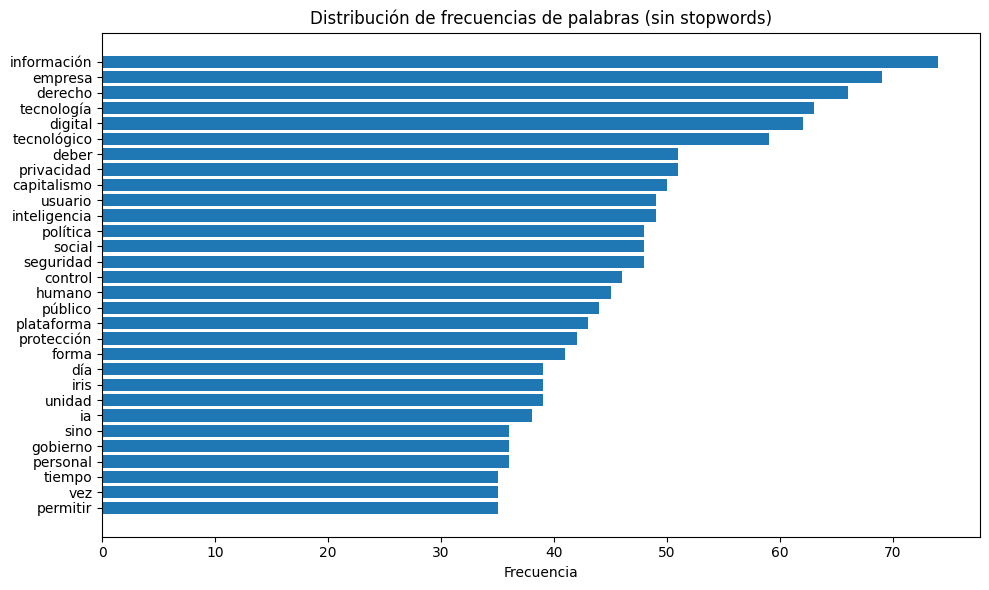

In [49]:
import matplotlib.pyplot as plt

# Convertir a DataFrame para graficar
freq_df = pd.DataFrame(freq_dist.most_common(30), columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(10, 6))
plt.barh(freq_df['Palabra'], freq_df['Frecuencia'])
plt.xlabel('Frecuencia')
plt.title('Distribución de frecuencias de palabras (sin stopwords)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Se visualiza a partir de esta distribución de frecuencias que todavía debe darse un refinado extra para palabras que aportan poco valor como:

"vez", "día", "tecnológico", "tecnología", etc

## Análisis con BoW/TF-IDF

### 3.1 Vectorización del corpus

### 3.2 Términos más frecuentes y distintivos

### 3.3 Matriz de similitud entre documentos

## Datos de commiteo - Ignorar

In [ ]:
## Para commits, guardar ruta como
## 003_barthou-gonzalo-nlp-integrador/notebook/analisis_integrador.ipynb